In [4]:
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from ast import literal_eval
import json

In [5]:
file_name = "M-5-[2-5000]-[AGE]-lcm.out"
output_file = f"queries_results/python_{file_name.replace('out','csv')}"

In [7]:
encoder = LabelEncoder()
encoder.classes_ = np.load(f'../../plots/encoders/{file_name}.npy')

def splited_links(file_name):
    links = pd.read_csv(f"../../plots/links/{file_name}")
    res = []
    links.apply(lambda x : [res.append((x["source"],x["target"], int(i) )) for i in x["user_id"].split(",")] ,axis=1)
    return  pd.DataFrame(res,columns=["source","target","user_id"])
def partial_df():
    # Groupes over two periods only
    links = splited_links(file_name)
    groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
    groups.drop(["itemset_name","property_values"],axis=1,inplace=True)
    groups = groups.drop(['depth',"a","size","support",],axis=1)
    groups["itemsets"] = groups["itemsets"].apply(lambda x :set(encoder.inverse_transform([int(i) for i in x.split()])))
    groups["user_ids"] =  groups["user_ids"].apply(literal_eval)
    links = links.merge(groups.reset_index(),left_on="source",right_on='index').merge(groups.reset_index(),left_on="target",right_on='index')
    links.drop(["source","target","index_x","index_y","user_ids_x","user_ids_y"],axis=1,inplace=True)
    return links
def full_df(file_name):
    # Groups over three periods only
    links = splited_links()
    links = links.merge(links,left_on=["target","user_id"],right_on=["source","user_id"]).drop(["source_y"],axis=1)
    
    groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
    groups.drop(["itemset_name","property_values","user_ids"],axis=1,inplace=True)
    groups = groups.drop(['depth',"size","support",],axis=1)
    groups["itemsets"] = groups["itemsets"].apply(lambda x :set(encoder.inverse_transform([int(i) for i in x.split()])))
    
    links = links.merge(groups,left_on="source_x",right_index=True).merge(groups,left_on="target_x",right_index=True).merge(groups,left_on="target_y",right_index=True)
    links = links.rename(columns={"itemsets":"itemsets_z","period":"period_z"})
    links.drop(["source_x","target_x","target_y"],axis=1,inplace=True)
    return links

with open("../../datasets/Total/ids_mapping.json","r") as file:
    mapping = json.load(file)
def extract_user_stats(x,columns):
    user = x["user_id"]
    for col in columns:
        for val in x[col]:
            res.append((user,col,val,x["period_x"]))

## Queries

In [6]:
df=full_df()
df.head()

,user_id,itemsets_x,period_x,AGE_x,itemsets_y,period_y,AGE_y,itemsets_z,period_z,AGE
0,464331,"{3158845901345, 451}",2017-04-01,50-65,"{11460024, 451}",2017-07-01,50-65,"{5000159493840, 3158845901345}",2018-04-01,50-65
2,464331,"{3158845901345, 451}",2017-04-01,50-65,"{11460024, 3660514082274}",2017-07-01,50-65,"{5000159493840, 3158845901345}",2018-04-01,50-65
1,464331,"{3158845901345, 451}",2017-04-01,50-65,"{11460024, 451}",2017-07-01,50-65,"{5000159493840, 3158845901345, 451}",2018-04-01,50-65
3,464331,"{3158845901345, 451}",2017-04-01,50-65,"{11460024, 3660514082274}",2017-07-01,50-65,"{5000159493840, 3158845901345, 451}",2018-04-01,50-65
4,187833,"{3158845901345, 451}",2017-04-01,50-65,"{451, 3660514101807}",2018-07-01,50-65,"{451, 11461013}",2018-08-01,50-65


In [11]:
df["loyalty1"] = df.apply(lambda x: x["itemsets_y"].intersection(x["itemsets_x"]),axis=1)
df["loyalty2"] = df.apply(lambda x: x["itemsets_y"].intersection(x["itemsets_z"]),axis=1)

df["promo_exclusive_products"] = df.apply(lambda x : x["itemsets_y"].difference(x["itemsets_x"]).difference(x["itemsets_z"]),axis=1)
df["replacement"] = df.apply(lambda x : x["itemsets_x"].intersection(x["itemsets_y"]).difference(x["itemsets_z"]),axis=1)
df["loyalty"] = df.apply(lambda x :x["itemsets_x"].intersection(x["itemsets_y"].intersection(x["itemsets_z"])),axis=1)

In [20]:
df.

,user_id,itemsets_x,period_x,AGE_x,itemsets_y,period_y,AGE_y,itemsets_z,period_z,AGE,loyalty1,loyalty2,promo_exclusive_products,replacement,loyalty
0,464331,"{3158845901345, 451}",2017-04-01,50-65,"{11460024, 451}",2017-07-01,50-65,"{5000159493840, 3158845901345}",2018-04-01,50-65,{451},{},{11460024},{451},{}
2,464331,"{3158845901345, 451}",2017-04-01,50-65,"{11460024, 3660514082274}",2017-07-01,50-65,"{5000159493840, 3158845901345}",2018-04-01,50-65,{},{},"{11460024, 3660514082274}",{},{}
1,464331,"{3158845901345, 451}",2017-04-01,50-65,"{11460024, 451}",2017-07-01,50-65,"{5000159493840, 3158845901345, 451}",2018-04-01,50-65,{451},{451},{11460024},{},{451}
3,464331,"{3158845901345, 451}",2017-04-01,50-65,"{11460024, 3660514082274}",2017-07-01,50-65,"{5000159493840, 3158845901345, 451}",2018-04-01,50-65,{},{},"{11460024, 3660514082274}",{},{}
4,187833,"{3158845901345, 451}",2017-04-01,50-65,"{451, 3660514101807}",2018-07-01,50-65,"{451, 11461013}",2018-08-01,50-65,{451},{451},{3660514101807},{},{451}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,979326,"{3393190008657, 3395978116004}",2019-10-01,35-49,"{3395978116004, 3178530414493}",2019-11-01,35-49,"{3182619560001, 3395978116004}",2019-12-01,35-49,{3395978116004},{3395978116004},{3178530414493},{},{3395978116004}
1582,979326,"{3393190008657, 3178530414493}",2019-10-01,35-49,"{3395978116004, 3178530414493}",2019-11-01,35-49,"{3393190008657, 3395978116004}",2019-12-01,35-49,{3178530414493},{3395978116004},{},{3178530414493},{}
1584,979326,"{3395978116004, 3178530414493}",2019-10-01,35-49,"{3395978116004, 3178530414493}",2019-11-01,35-49,"{3393190008657, 3395978116004}",2019-12-01,35-49,"{3395978116004, 3178530414493}",{3395978116004},{},{3178530414493},{3395978116004}
1586,979326,"{3393190008657, 3395978116004}",2019-10-01,35-49,"{3395978116004, 3178530414493}",2019-11-01,35-49,"{3393190008657, 3395978116004}",2019-12-01,35-49,{3395978116004},{3395978116004},{3178530414493},{},{3395978116004}


# Stats

In [22]:
users= pd.read_csv("../../datasets/Total/users.csv",sep=";")
items = pd.read_csv("../../datasets/Total/items.csv",index_col=0).drop("IDS_LIST",axis=1)
res = []
queries_columns = df.columns.tolist()[7:]
df.apply(lambda x : extract_user_stats(x,queries_columns),axis=1)
stats_df = pd.DataFrame(res,columns=["CUST_ID","query_type","ARTICLE_ID","period"])
stats_df = stats_df.merge(users).merge(items)
stats_df.head(10)
# stats_df.to_csv("stats.csv")

,CUST_ID,query_type,ARTICLE_ID,period,SEX,AGE,DEPARTEMENT,DESCRIPTION
0,464331,itemsets_z,5000159493840,2017-04-01,M,50-65,59,M&M'S BLEU BLANC ROUGE
1,464331,itemsets_z,5000159493840,2017-04-01,M,50-65,59,M&M'S BLEU BLANC ROUGE
2,464331,itemsets_z,5000159493840,2017-04-01,M,50-65,59,M&M'S BLEU BLANC ROUGE
3,464331,itemsets_z,5000159493840,2017-04-01,M,50-65,59,M&M'S BLEU BLANC ROUGE
4,464331,promo_exclusive_products,5000159493840,2017-07-01,M,50-65,59,M&M'S BLEU BLANC ROUGE
5,464331,promo_exclusive_products,5000159493840,2017-07-01,M,50-65,59,M&M'S BLEU BLANC ROUGE
6,464331,promo_exclusive_products,5000159493840,2017-07-01,M,50-65,59,M&M'S BLEU BLANC ROUGE
7,464331,promo_exclusive_products,5000159493840,2017-07-01,M,50-65,59,M&M'S BLEU BLANC ROUGE
8,464331,promo_exclusive_products,5000159493840,2017-07-01,M,50-65,59,M&M'S BLEU BLANC ROUGE
9,464331,promo_exclusive_products,5000159493840,2017-07-01,M,50-65,59,M&M'S BLEU BLANC ROUGE


In [14]:
stats_df[stats_df.ARTICLE_ID==3439495300031].query_type.value_counts()

Series([], Name: query_type, dtype: int64)

### By users

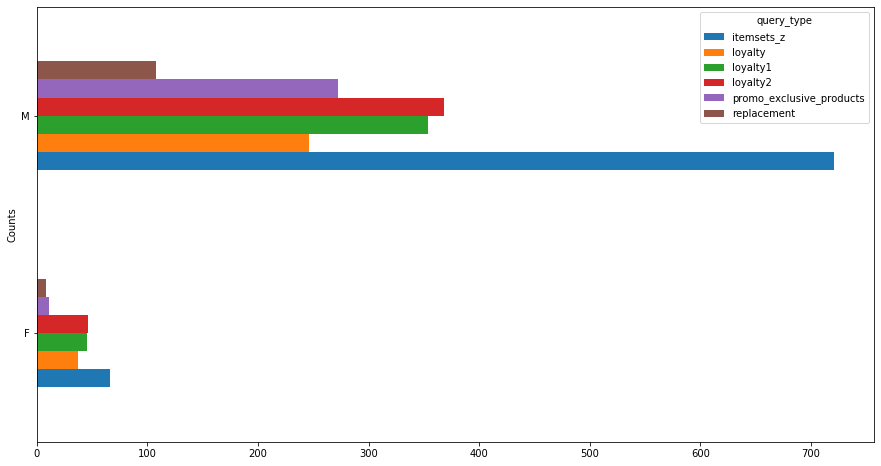

In [15]:
ax = stats_df.groupby(["SEX"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

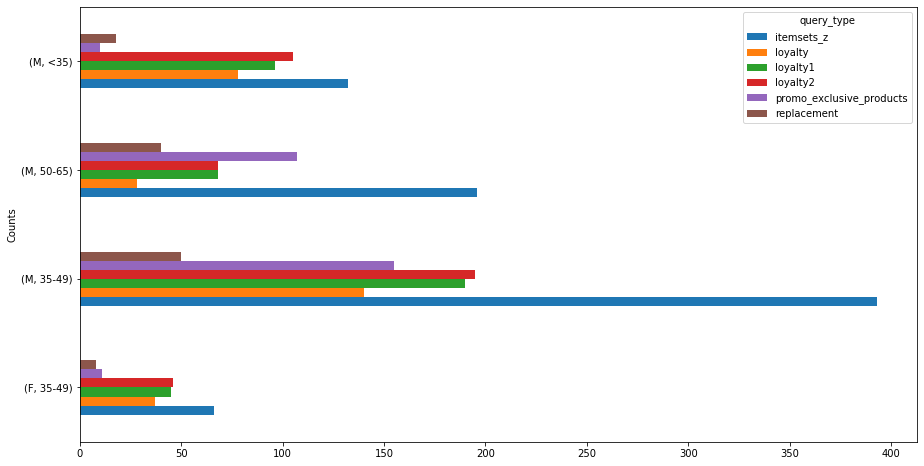

In [16]:
ax = stats_df.groupby(["SEX","AGE"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

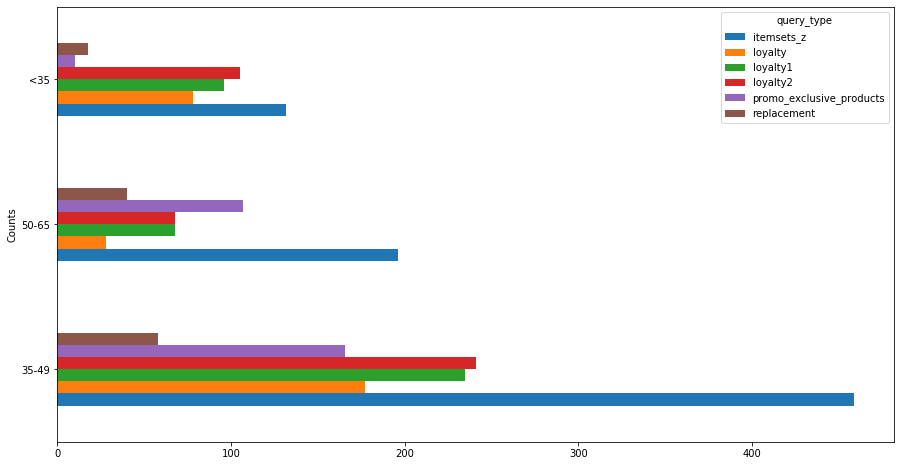

In [17]:
ax = stats_df.groupby(["AGE"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

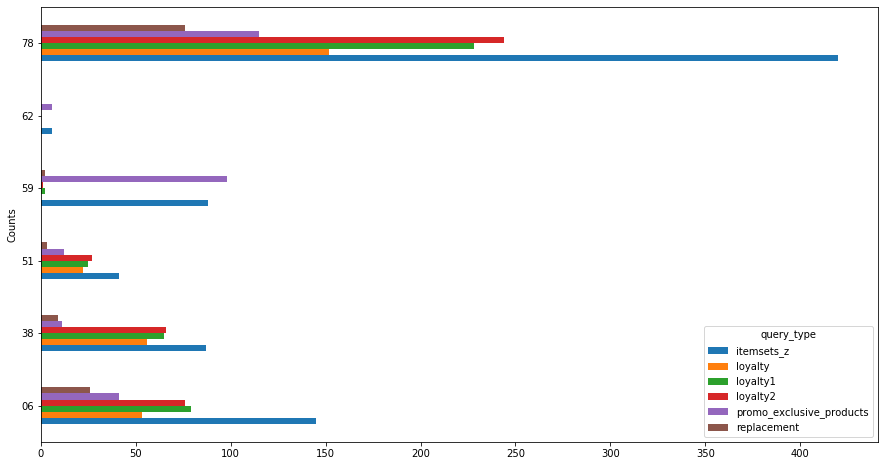

In [18]:
ax = stats_df.groupby(["DEPARTEMENT"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

### By items

/home/abdelouahab/3env/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/abdelouahab/3env/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)


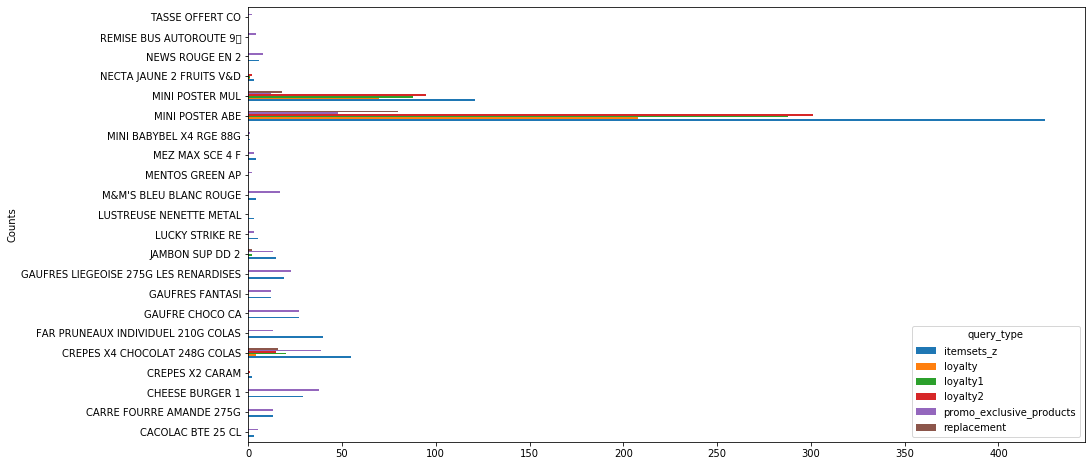

In [19]:
ax = stats_df.groupby(["DESCRIPTION"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

### DRAFT

In [25]:
groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
groups.drop(["itemset_name","property_values"],axis=1,inplace=True)
groups[groups.itemsets.apply(lambda x : "4120" in x )]

,user_ids,support,itemsets,period,depth,size,a
543,"[135477, 156490, 164382, 179013, 185798, 19841...",58,4120,2018-09-01,0.000000,58,1
544,"[156490, 540071, 548581, 888898, 984812]",5,4120 4160,2018-09-01,0.000000,5,1
545,"[209038, 240151, 350965, 480899, 548581, 84523...",7,4120 3007,2018-09-01,0.000000,7,1
784,"[101105, 124784, 171396, 189197, 199984, 20903...",40,4120,2018-12-01,0.333333,40,1
1222,"[101205, 144221, 157796, 198410, 199984, 20903...",55,4120,2019-02-01,0.666667,55,1
1526,"[144221, 521161, 778698, 1189972, 1233005]",5,1857 4120,2019-02-01,0.666667,5,1


In [39]:
stats_df[(stats_df.ARTICLE_ID==3425909000796)&(stats_df.query_type=="loyalty")]

,CUST_ID,query_type,ARTICLE_ID,SEX,AGE,DEPARTEMENT,DESCRIPTION
8835,209038,loyalty,3425909000796,F,50-65,39,PROPANE 35KG FINAGAZ
8838,209038,loyalty,3425909000796,F,50-65,39,PROPANE 35KG FINAGAZ
8859,199984,loyalty,3425909000796,M,50-65,59,PROPANE 35KG FINAGAZ
9042,478604,loyalty,3425909000796,M,35-49,78,PROPANE 35KG FINAGAZ
9045,778698,loyalty,3425909000796,M,35-49,62,PROPANE 35KG FINAGAZ
9050,778698,loyalty,3425909000796,M,35-49,62,PROPANE 35KG FINAGAZ
9053,1236845,loyalty,3425909000796,M,50-65,62,PROPANE 35KG FINAGAZ


In [32]:
a = []
a.append(set.intersection(*[groups.loc[i].user_ids for i in [543,784,545]]))
a.append(set.intersection(*[groups.loc[i].user_ids for i in [543,784,1526]]))
        
a.append(set.intersection(*[groups.loc[i].user_ids for i in [544,784,545]]))
a.append(set.intersection(*[groups.loc[i].user_ids for i in [544,784,1526]]))

a.append(set.intersection(*[groups.loc[i].user_ids for i in [545,784,545]]))
a.append(set.intersection(*[groups.loc[i].user_ids for i in [545,784,1526]]))
a

[{209038, 480899}, {778698}, set(), set(), {209038, 480899}, set()]

In [26]:
from ast import literal_eval
groups.user_ids = groups.user_ids.apply(lambda x : set(literal_eval(x)))

In [41]:
stats_df[stats_df.ARTICLE_ID==3425909000796].query_type.value_counts()

adoption                    88
promo_exclusive_products    80
loyalty1                    28
replacement                 21
loyalty2                    15
loyalty                      7
Name: query_type, dtype: int64

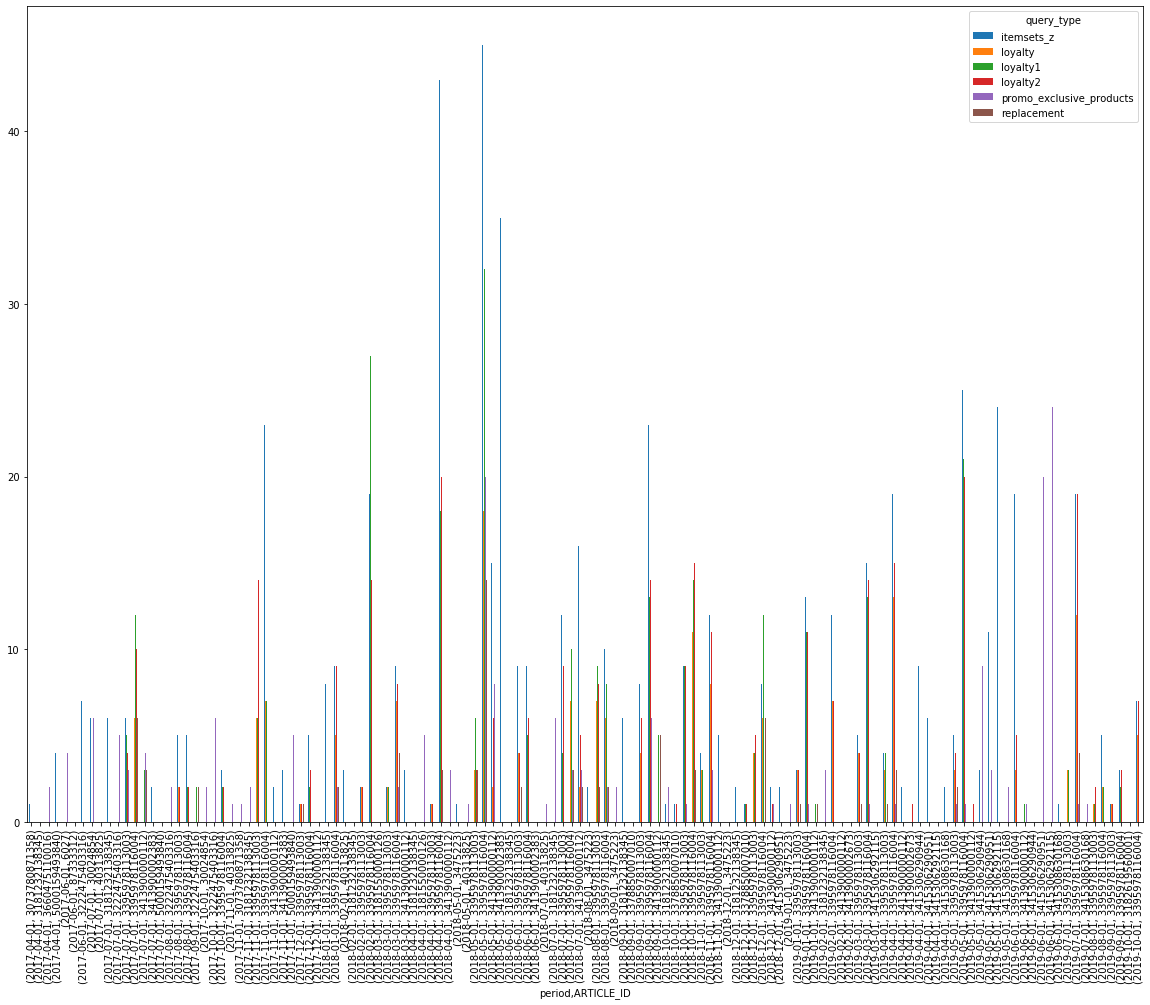

In [37]:
stats_df[["period","ARTICLE_ID","query_type"]].groupby(["period","ARTICLE_ID","query_type"]).size().unstack().plot.bar(figsize=(20,15))